In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Current working directory: /shared_folder/eas_508_project


In [2]:
#Create Remove Plays func for clean_data func
def remove_plays(dataframe):
    df = dataframe.copy()

    formation = df['offense_formation'].notna()
    personnel = df['offense_personnel'].notna()
    no_play = df['play_type'] != 'no_play'
    kneel = df['qb_kneel'] == 0
    spike = df['qb_spike'] == 0

    df = df[formation & personnel & no_play & kneel & spike].drop(columns=['qb_kneel','qb_spike'])

    df = df[df['down'].notna()]

    return df

In [3]:
pbp_path = 'data/raw/pbp_data/'

pbp_name = 'pbp_2016.csv'

fb_df = pd.read_csv(pbp_path + pbp_name)
shape = fb_df.shape
columns = fb_df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

fb_df.head()

/tmp/ipykernel_68734/3081738536.py:5: DtypeWarning: Columns (196,197,199,200,206,207,210,211,214,215,220,221,222,223,226,227,235,236,237,265,266,270,271,272,277,279,280,300,301) have mixed types. Specify dtype option on import or set low_memory=False.
  fb_df = pd.read_csv(pbp_path + pbp_name)


✔✔✔ File Loaded

Shape: (47651, 389)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type', 'defense_coverage_type', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_poin

nflverse_game_id  play_id possession_team offense_formation  \
0  2016_01_BUF_BAL        1             NaN               NaN   
1  2016_01_BUF_BAL       36             BUF               NaN   
2  2016_01_BUF_BAL       58             BAL            I_FORM   
3  2016_01_BUF_BAL       85             BAL           SHOTGUN   
4  2016_01_BUF_BAL      109             BAL           SHOTGUN   

  offense_personnel  defenders_in_box defense_personnel  \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2  2 RB, 1 TE, 2 WR               8.0  4 DL, 3 LB, 4 DB   
3  2 RB, 1 TE, 2 WR               6.0  4 DL, 3 LB, 4 DB   
4  2 RB, 1 TE, 2 WR               7.0  4 DL, 3 LB, 4 DB   

   number_of_pass_rushers                                    players_on_play  \
0                     NaN                                                NaN   
1                     NaN  40078;40151;37977;36060;40494;40053;40253;4011...   
2                     NaN  38540;41302;40078;35553;38582;43295;40053;4336...   
3                     3.0  41302;40078;38540;35553;43295;38582;40053;4336...   
4                     NaN  40078;38540;41302;35553;43295;38582;40053;4336...   

                                     offense_players  ... out_of_bounds  \
0                                                NaN  ...             0   
1  00-0030041;00-0030073;00-0029799;00-0030433;00...  ...             0   
2  00-0029892;00-0027714;00-0032965;00-0029893;00...  ...             1   
3  00-0029892;00-0027714;00-0032965;00-0029893;00...  ...             0   
4  00-0029892;00-0027714;00-0032965;00-0029893;00...  ...             0   

   home_opening_kickoff    qb_epa  xyac_epa  xyac_mean_yardage  \
0                     1  0.000000       NaN                NaN   
1                     1 -0.955114       NaN                NaN   
2                     1  0.336466       NaN                NaN   
3                     1  0.644540  1.567466           9.753489   
4                     1 -0.546209       NaN                NaN   

  xyac_median_yardage xyac_success   xyac_fd     xpass    pass_oe  
0                 NaN          NaN       NaN       NaN        NaN  
1                 NaN          NaN       NaN       NaN        NaN  
2                 NaN          NaN       NaN  0.460759 -46.075901  
3                 8.0      0.63767  0.530295  0.426425  57.357508  
4                 NaN          NaN       NaN  0.456597 -45.659652  

[5 rows x 389 columns]

In [4]:
df = remove_plays(fb_df)

In [5]:
formation_info = ['offense_formation','offense_personnel','defenders_in_box','defense_personnel','n_offense','n_defense']

df[formation_info].head()

offense_formation offense_personnel  defenders_in_box defense_personnel  \
2            I_FORM  2 RB, 1 TE, 2 WR               8.0  4 DL, 3 LB, 4 DB   
3           SHOTGUN  2 RB, 1 TE, 2 WR               6.0  4 DL, 3 LB, 4 DB   
4           SHOTGUN  2 RB, 1 TE, 2 WR               7.0  4 DL, 3 LB, 4 DB   
5            I_FORM  2 RB, 1 TE, 2 WR               7.0  4 DL, 3 LB, 4 DB   
6            I_FORM  1 RB, 2 TE, 2 WR               8.0  4 DL, 3 LB, 4 DB   

   n_offense  n_defense  
2         11         11  
3         11         11  
4         11         11  
5         11         11  
6         11         11

In [6]:
df = df[(df['n_offense'] == 11) & (df['n_defense'] == 11)].drop(columns=['n_offense','n_defense'])

In [7]:
#Convert Offense Personnel to Dictionary Storage for easy recall
df['personnel_dict'] = df['offense_personnel'].apply(lambda x: {pos: int(count) for count, pos in (p.strip().split(' ') for p in x.split(','))})

df['QB'] = 1
df['OL'] = 5

personnel_titles = ['RB','TE','WR','OTHER']

for pos in personnel_titles:
    df[f'{pos}'] = 0

def update_personnel_counts(row):
    for k,v in row['personnel_dict'].items():
        if k in personnel_titles:
            row[k] += v
        else:
            if k == 'QB':
                row[k] = v
            elif k == 'OL':
                row[k] = v
            else:
                row['OTHER'] += v
    return row

df = df.apply(update_personnel_counts, axis=1)

In [8]:
df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)

df['bigs'] = df['OL']+df['TE']-5
df['personnel_num'] = df.apply(lambda x: f'{x['bigs']}{x['RB']}', axis=1)

df['personnel_num']

/tmp/ipykernel_68734/389622894.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)
/tmp/ipykernel_68734/389622894.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bigs'] = df['OL']+df['TE']-5
/tmp/ipykernel_68734/389622894.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

2        12
3        12
4        12
5        12
6        21
         ..
47644    11
47645    01
47646    11
47648    32
47649    11
Name: personnel_num, Length: 29149, dtype: object

In [9]:
cols_to_use = ['down','ydstogo','yardline_100','offense_formation','personnel_num','extra_lineman_flag','play_type','score_differential','success','epa','wp']

df = df[cols_to_use]
df = df[(.1 < df['wp']) & (df['wp'] < .9)]

run_df = df[df['play_type']=='run'].drop(columns='play_type')
pass_df = df[df['play_type']=='pass'].drop(columns='play_type')

In [10]:
run_df = pd.get_dummies(run_df, columns=['offense_formation','personnel_num'], dtype=int)
run_in = run_df.drop(columns=['success','epa','wp'])

pass_df = pd.get_dummies(pass_df, columns=['offense_formation','personnel_num'], dtype=int)
pass_in = pass_df.drop(columns=['success','epa','wp'])

In [11]:
run_in

down  ydstogo  yardline_100  extra_lineman_flag  score_differential  \
2       1.0       10          86.0                   0                 0.0   
4       1.0       10          75.0                   0                 0.0   
6       3.0        1          66.0                   0                 0.0   
25      1.0       10          91.0                   0                 0.0   
28      2.0        5          49.0                   0                 0.0   
...     ...      ...           ...                 ...                 ...   
47524   1.0       10          27.0                   0               -14.0   
47525   2.0        6          23.0                   0               -14.0   
47630   2.0        1           1.0                   0                -8.0   
47638   1.0       10          65.0                   0                 0.0   
47646   1.0       10          25.0                   0                 0.0   

       offense_formation_EMPTY  offense_formation_I_FORM  \
2                            0                         1   
4                            0                         0   
6                            0                         1   
25                           0                         0   
28                           0                         0   
...                        ...                       ...   
47524                        0                         0   
47525                        0                         1   
47630                        0                         0   
47638                        0                         0   
47646                        0                         0   

       offense_formation_JUMBO  offense_formation_PISTOL  \
2                            0                         0   
4                            0                         0   
6                            0                         0   
25                           0                         0   
28                           0                         0   
...                        ...                       ...   
47524                        0                         0   
47525                        0                         0   
47630                        0                         0   
47638                        1                         0   
47646                        0                         0   

       offense_formation_SHOTGUN  ...  personnel_num_11  personnel_num_12  \
2                              0  ...                 0                 1   
4                              1  ...                 0                 1   
6                              0  ...                 0                 0   
25                             0  ...                 0                 0   
28                             1  ...                 1                 0   
...                          ...  ...               ...               ...   
47524                          0  ...                 1                 0   
47525                          0  ...                 0                 1   
47630                          0  ...                 1                 0   
47638                          0  ...                 0                 0   
47646                          1  ...                 1                 0   

       personnel_num_13  personnel_num_20  personnel_num_21  personnel_num_22  \
2                     0                 0                 0                 0   
4                     0                 0                 0                 0   
6                     0                 0                 1                 0   
25                    0                 0                 1                 0   
28                    0                 0                 0                 0   
...                 ...               ...               ...               ...   
47524                 0                 0                 0                 0   
47525                 0                 0              

In [12]:
train_X_run, test_X_run, train_y_run, test_y_run = train_test_split(run_in, run_df['success'], train_size=.8, random_state=42)

In [117]:
log = LogisticRegression()

log.fit(train_X_run, train_y_run)
y_pred = log.predict(test_X_run)

conf = ConfusionMatrixDisplay(confusion_matrix(test_y_run, y_pred))


/opt/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
train_X_pass, test_X_pass, train_y_pass, test_y_pass = train_test_split(pass_in, pass_df['success'], train_size=.8, random_state=42)

log = LogisticRegression()

log.fit(train_X_pass, train_y_pass)
y_pred = log.predict(test_X_pass)

conf = ConfusionMatrixDisplay(confusion_matrix(test_y_pass, y_pred))


/opt/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


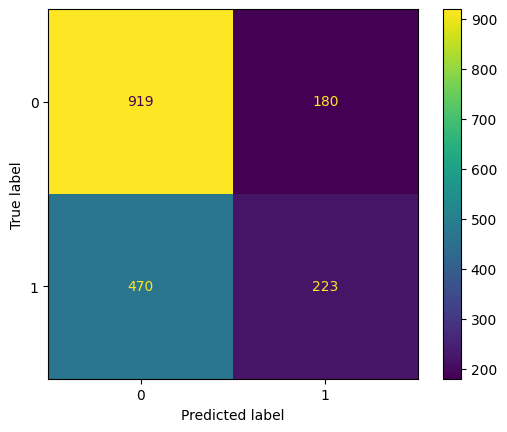

In [118]:
conf.plot()

In [119]:
accuracy_score(y_pred, test_y_run)

0.6372767857142857

In [ ]:
print(run_df['success'].mean(), pass_df['success'].mean())

0.40736607142857145 0.46235506700798074


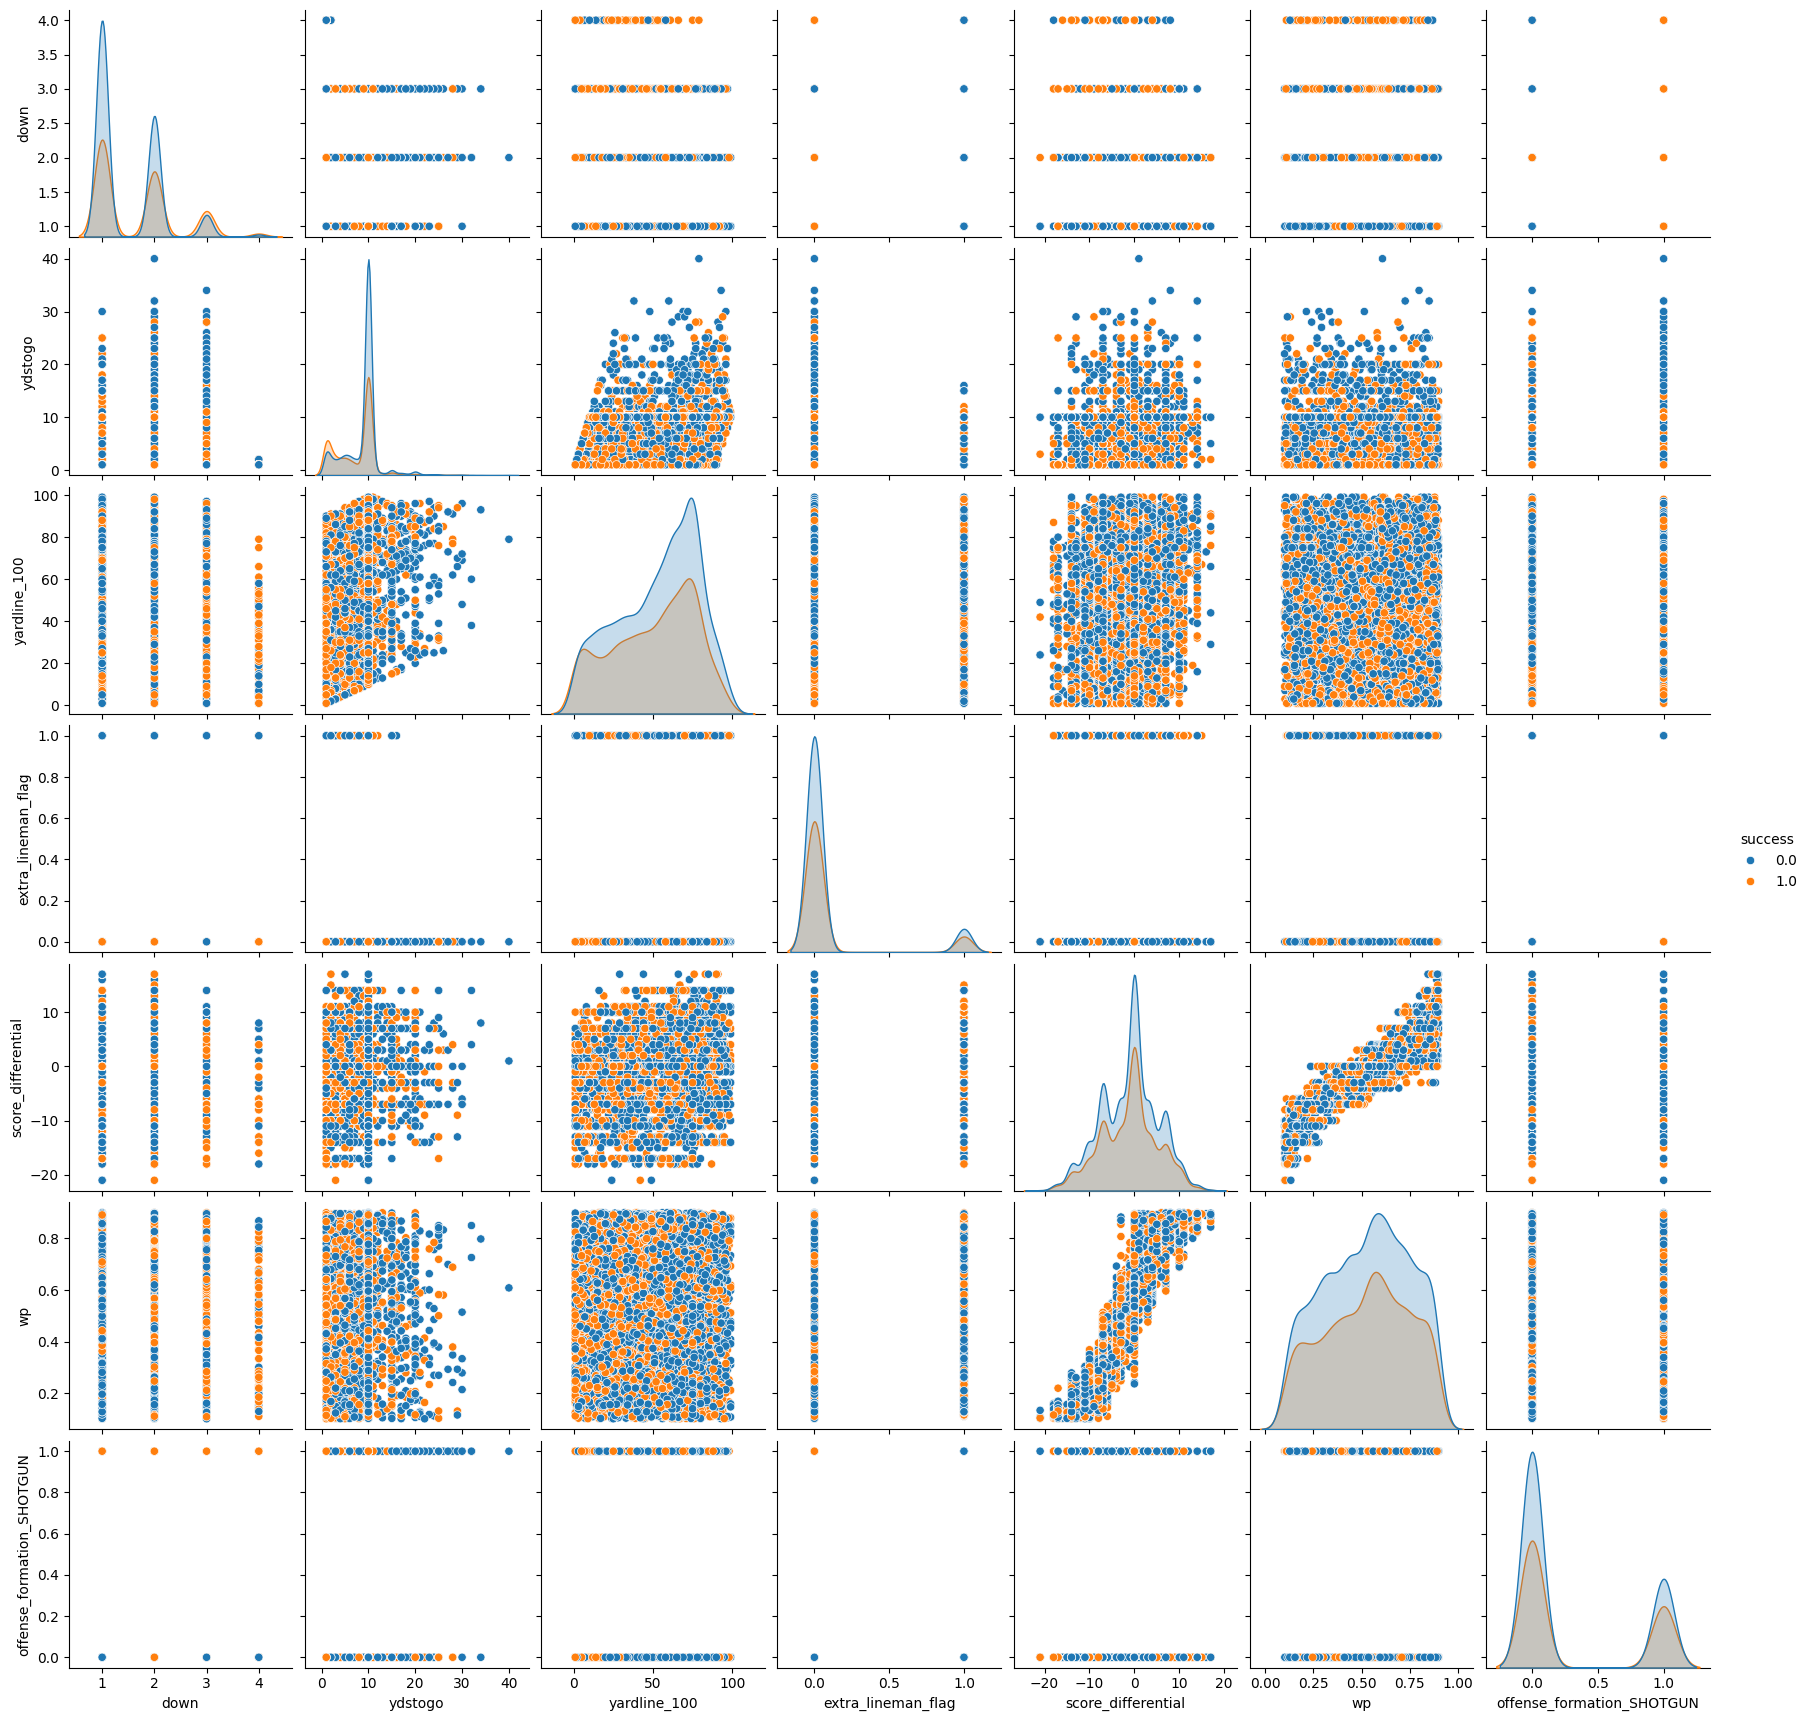

In [ ]:
sns.pairplot(data=run_df.drop(columns=['epa','offense_formation_I_FORM','offense_formation_EMPTY','offense_formation_JUMBO','offense_formation_PISTOL','offense_formation_SINGLEBACK','offense_formation_WILDCAT']), hue='success')

Points of note:
- 1st down rushes have a very low success rate, this is probabily due to the large amount of yards needed to get a success. 2nd and 3rd down on average should require less yards thus they have a higher rate
- Running from ~10 yards to go is a death sentence, this will need to be explored more deeply as this line does have more points than any other line because 1st and 10 and then subsequent downs
- Running from 1-2 yards to go is the move and has positive chance of success
- Teams run more successfully inside their own 5 yard line, could be low # of occurences
- Score Differential does not seem to have much difference on success rate, wp is the same way

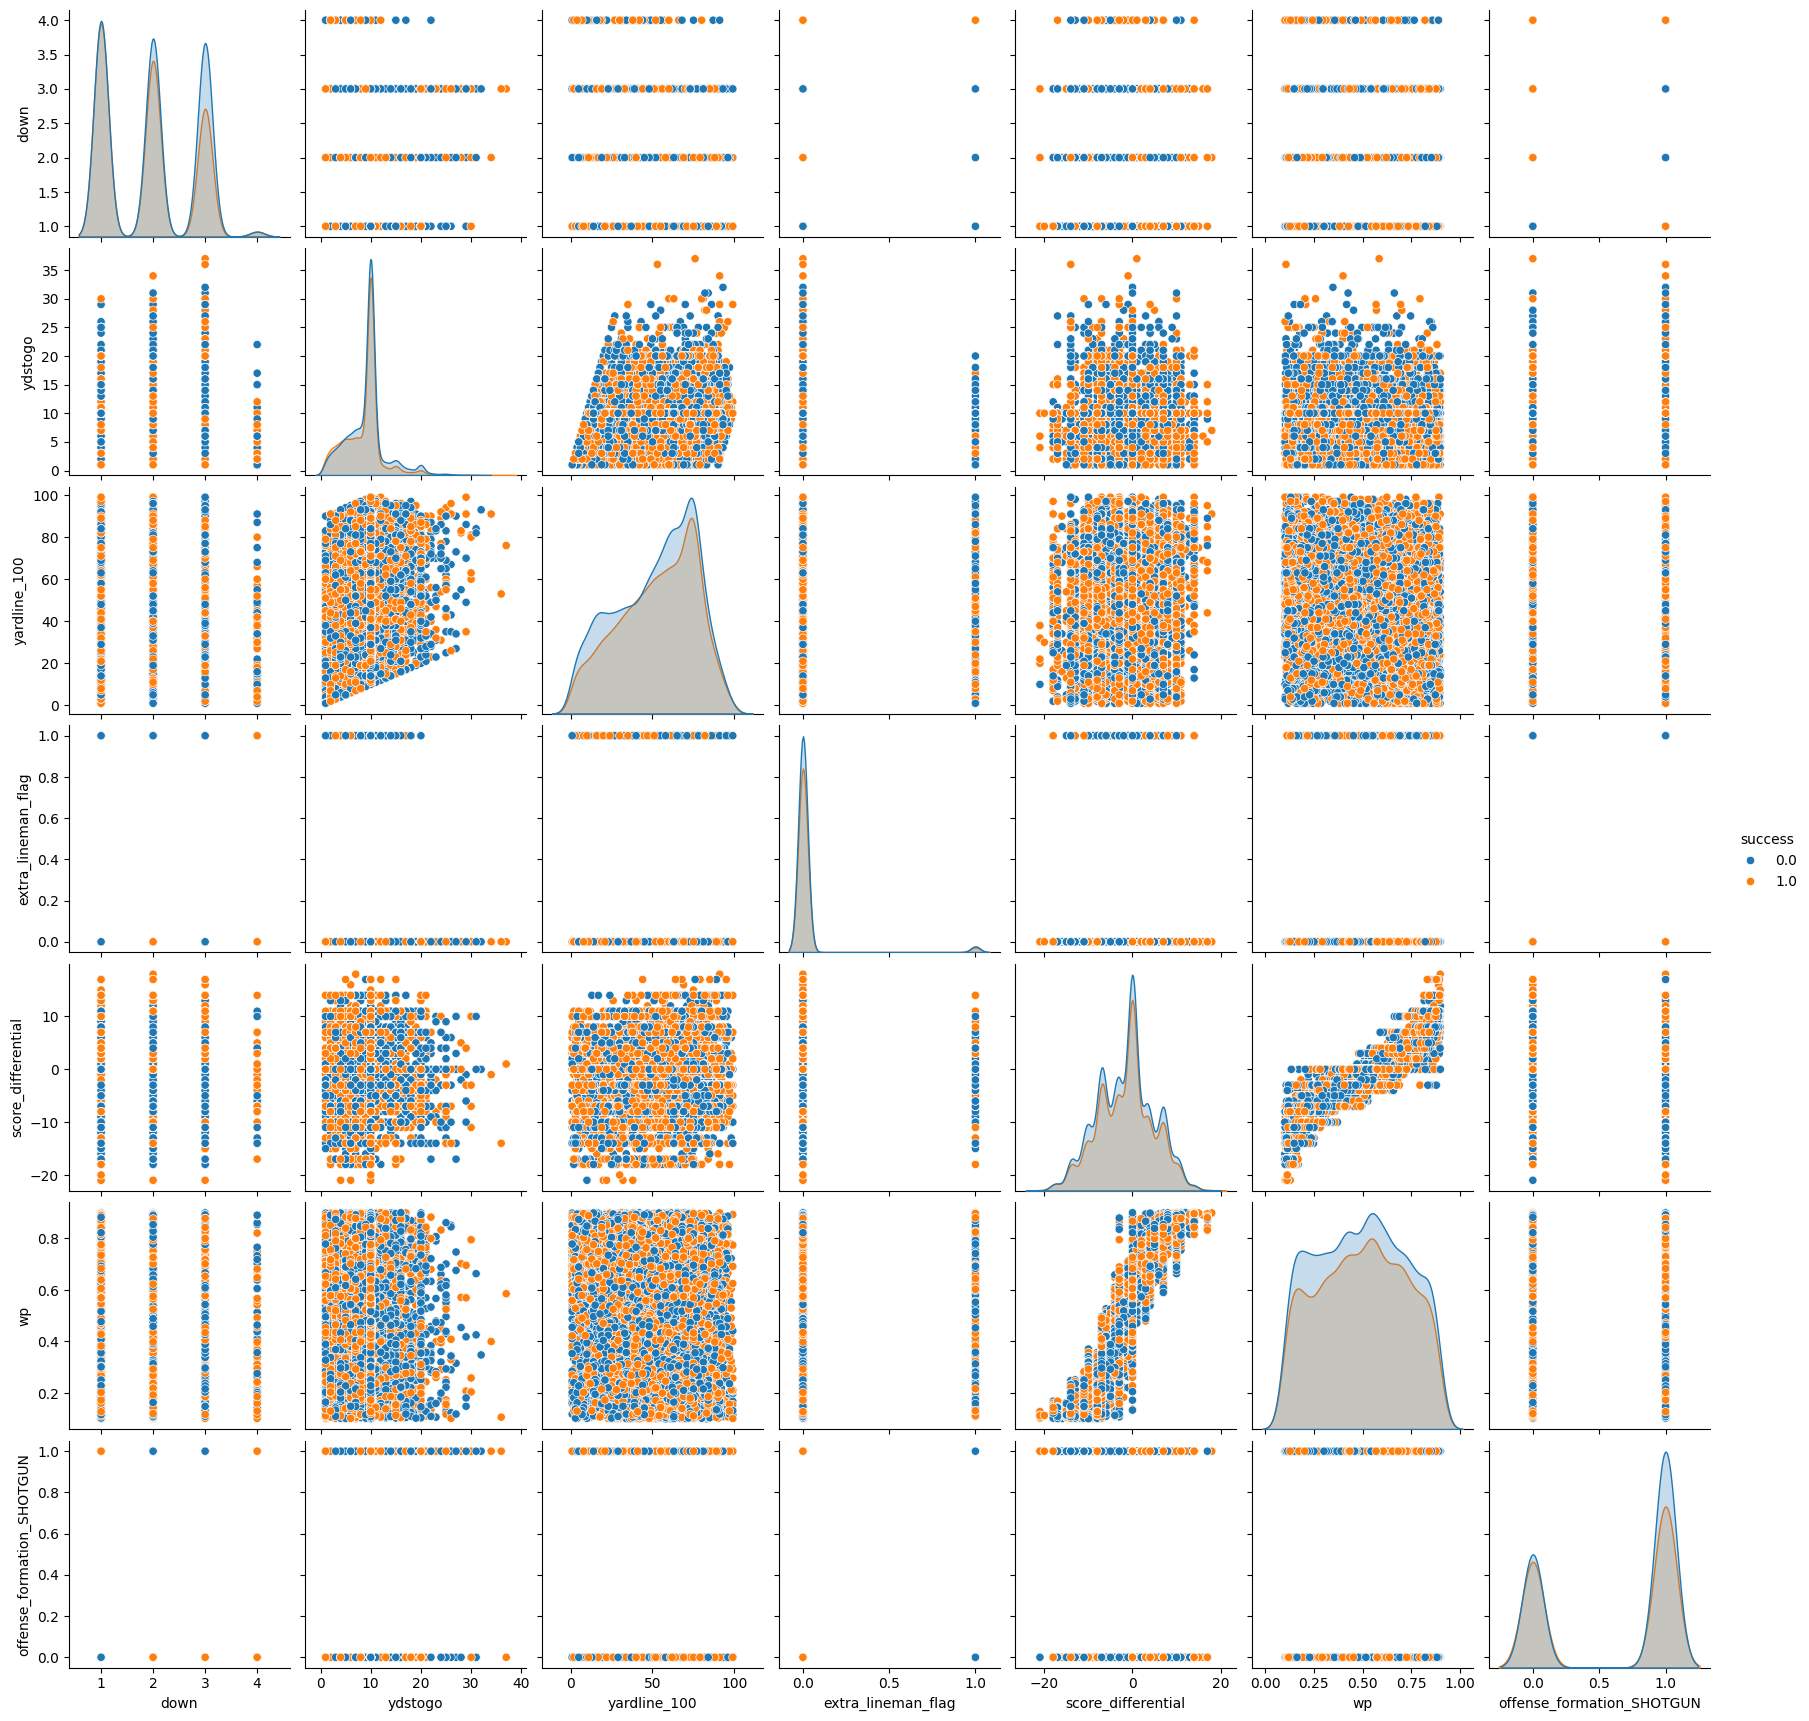

In [ ]:
sns.pairplot(data=pass_df.drop(columns=['epa','offense_formation_I_FORM','offense_formation_EMPTY','offense_formation_JUMBO','offense_formation_PISTOL','offense_formation_SINGLEBACK','offense_formation_WILDCAT']), hue='success')

- Passing is a bit more interesting, success rate at any given point is much more closely aligned towards 50/50 while running seemed closer to 60/40. On yardline the success rate seems to decrease aruond the 50 yard line and reincrease above it. This might coincide with a switch in aggression or might be due to passing situations and penalties being centered there
- wp does not seem to correlate, well to success rate there is a dip in success when wp is very low but otherwise its no connection
- Shotgun suprisingly has a drop in success rate
- 1st down passes seem to havea greater success than 2nd and 3rd down passes

Very hard to find relational data in plots

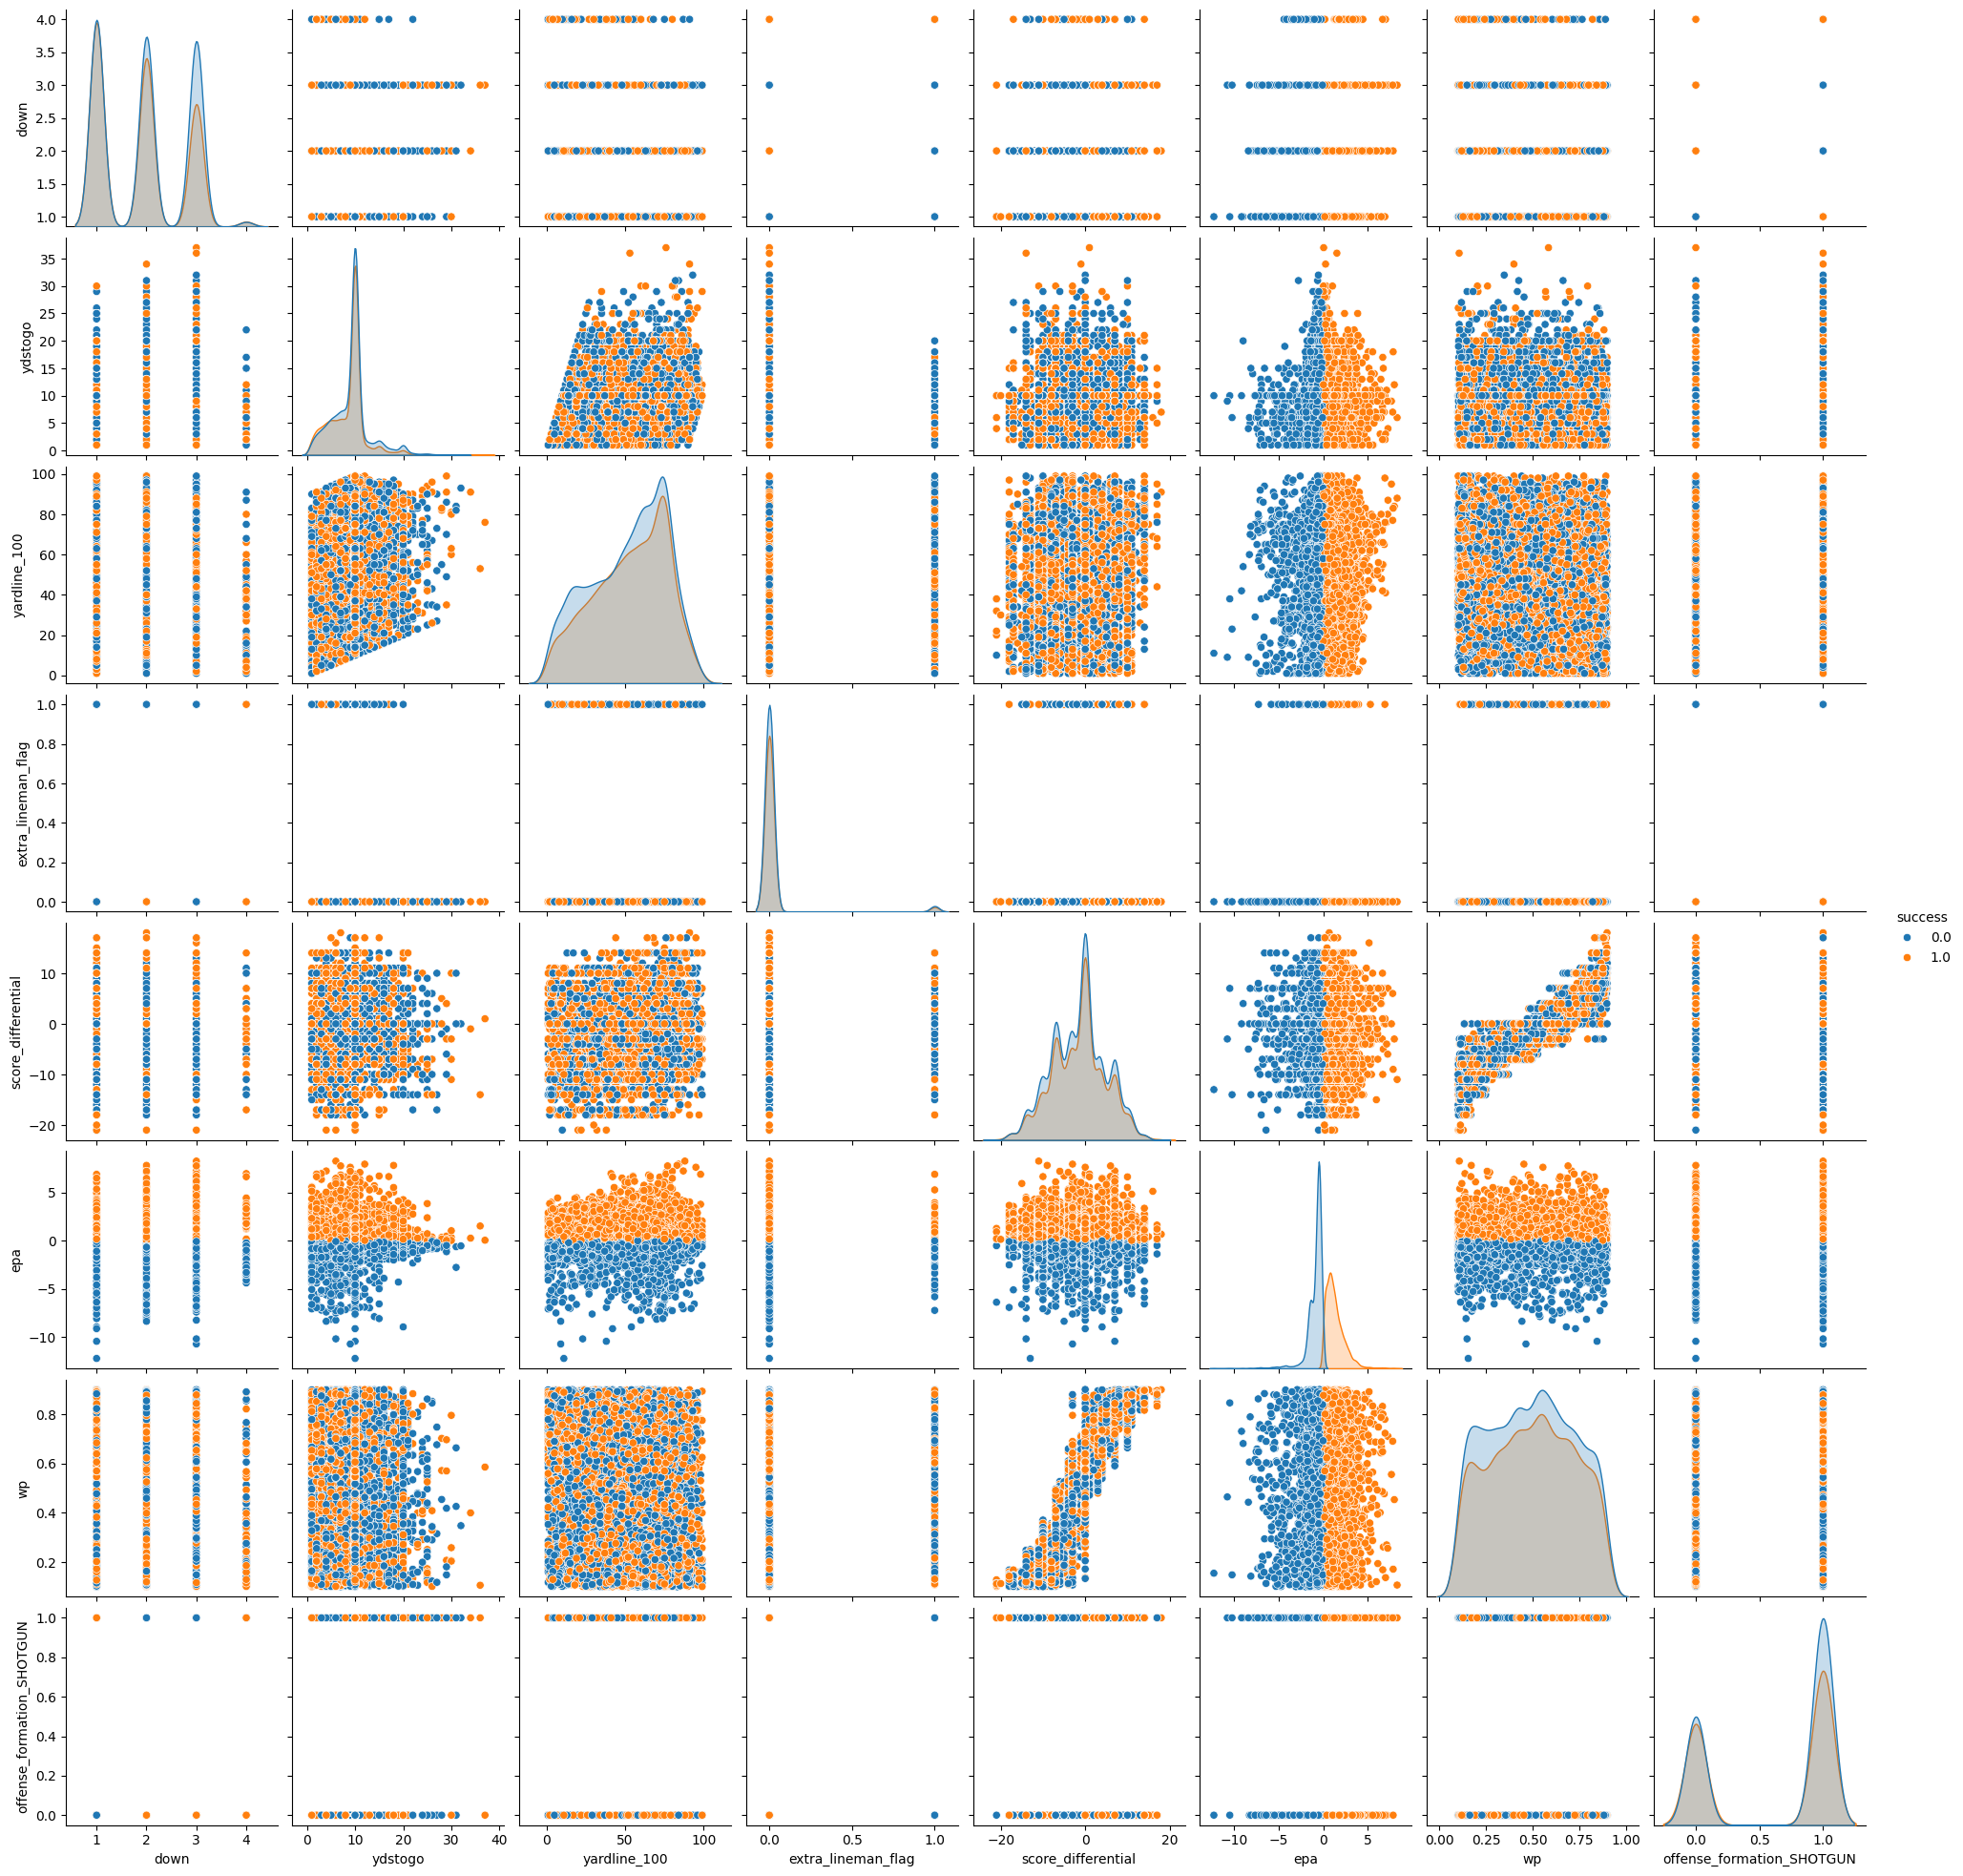

In [ ]:
sns.pairplot(data=pass_df.drop(columns=['offense_formation_I_FORM','offense_formation_EMPTY','offense_formation_JUMBO','offense_formation_PISTOL','offense_formation_SINGLEBACK','offense_formation_WILDCAT']), hue='success')

In [138]:
params = {
    'n_estimators':[50,100,200,400,600,800,100],
    'learning_rate':[.01,.05,.1,.15,.20,.25],
    'max_depth':[3,5,7,9,11,13],
    'subsample':[1,.95,.9,.85,.8,.75]
}

xgb_test = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

grid = GridSearchCV(
    estimator=xgb_test,
    param_grid=params,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_X_run, train_y_run)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 1512 candidates, totalling 4536 fits


KeyboardInterrupt: 

In [186]:
accuracy_score(test_y_run, y_pred_run)

0.6043526785714286

In [187]:
float(1 - test_y_run.mean())

0.61328125

In [ ]:
xgb_500 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=100, learning_rate=.1, max_depth=3, subsample=.8)

xgb_500.fit(train_X_run, train_y_run)
y_pred_run = xgb_500.predict(test_X_run)

Threshold 0.4: Precision=0.398, Recall=0.840, Accuracy=0.447
Threshold 0.425: Precision=0.412, Recall=0.749, Accuracy=0.489
Threshold 0.45: Precision=0.438, Recall=0.636, Accuracy=0.543
Threshold 0.475: Precision=0.460, Recall=0.525, Accuracy=0.578
Threshold 0.5: Precision=0.488, Recall=0.462, Accuracy=0.604
Threshold 0.525: Precision=0.503, Recall=0.385, Accuracy=0.615
Threshold 0.55: Precision=0.505, Recall=0.319, Accuracy=0.616
Threshold 0.575: Precision=0.522, Recall=0.278, Accuracy=0.622
Threshold 0.6: Precision=0.538, Recall=0.242, Accuracy=0.627


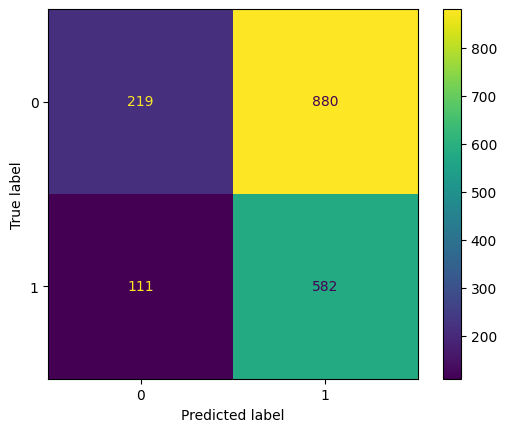

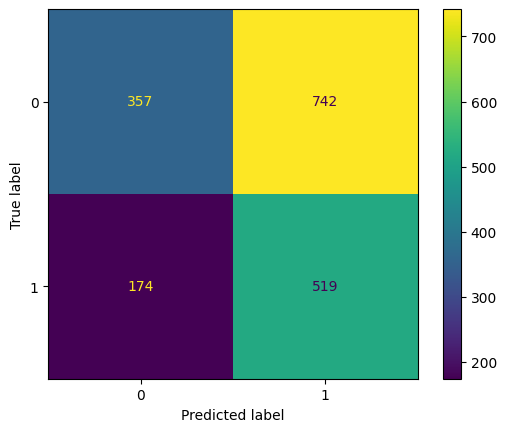

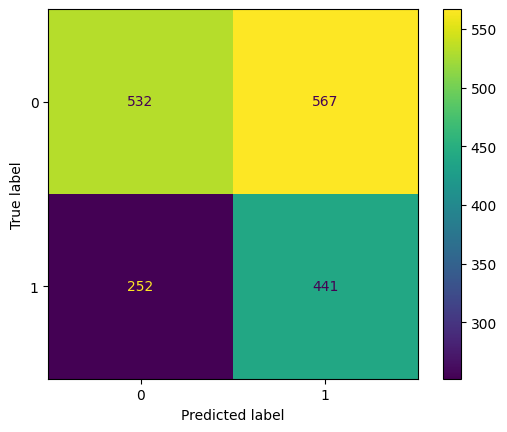

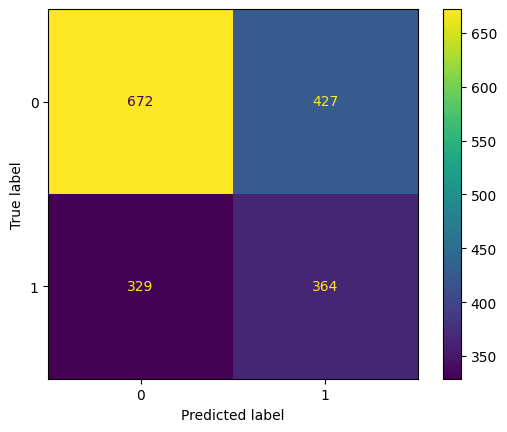

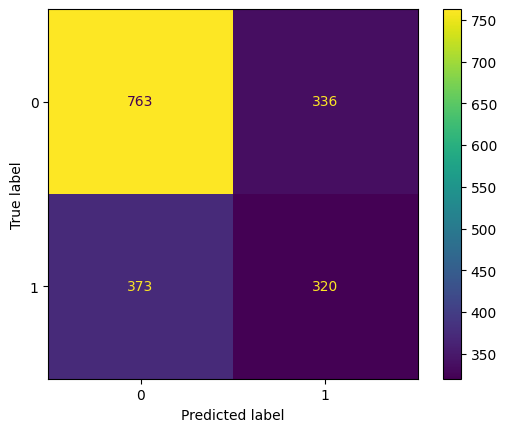

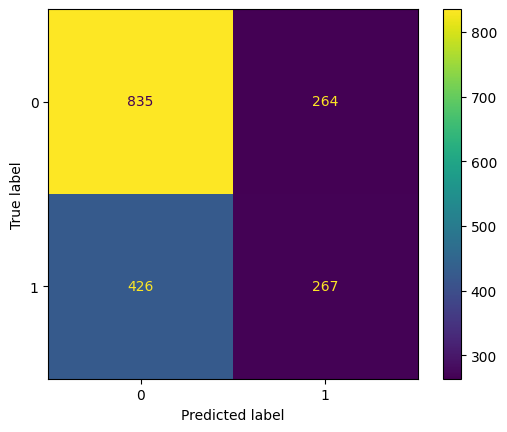

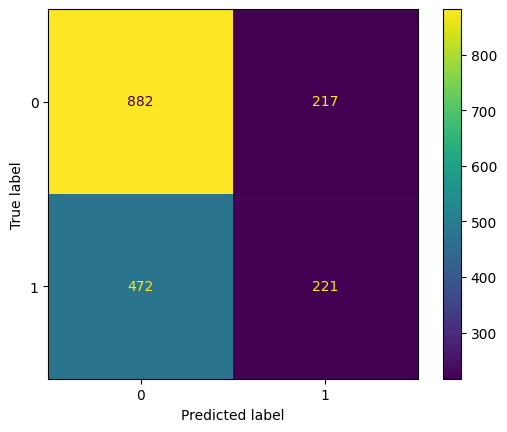

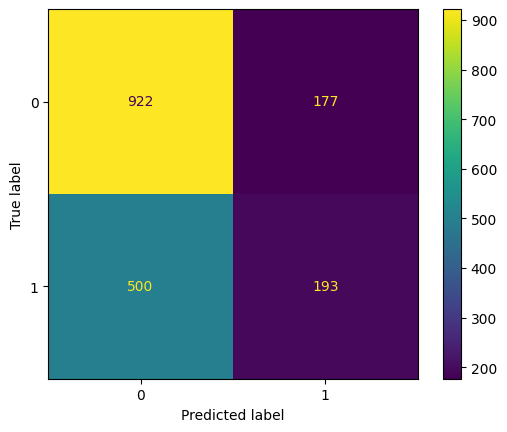

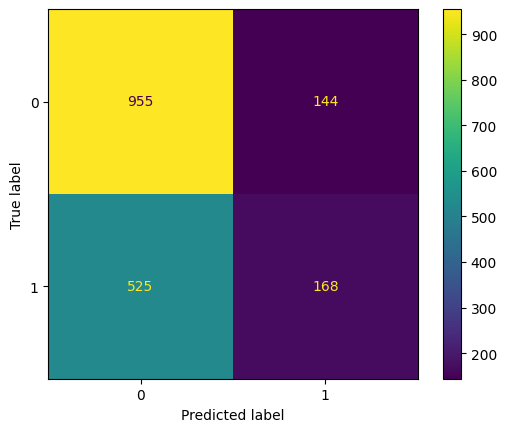

In [189]:
y_proba = xgb_500.predict_proba(test_X_run)[:,1]

for t in [0.4, .425, 0.45, .475, 0.5, .525, .55, .575, .6]:
    y_pred_thresh = (y_proba >= t).astype(int)
    precision = precision_score(test_y_run, y_pred_thresh)
    recall = recall_score(test_y_run, y_pred_thresh)
    acc = accuracy_score(test_y_run, y_pred_thresh)
    print(f"Threshold {t}: Precision={precision:.3f}, Recall={recall:.3f}, Accuracy={acc:.3f}")
    ConfusionMatrixDisplay(confusion_matrix(test_y_run, y_pred_thresh)).plot()


Plenty of issues with our prediction program currently. May need to consider additional features derived from our current feature set as well as more imported data.
Derived:
- ydstosuccess - based on success rate calculations, get ydstosuccess ie 50% of ydstogo on 1st, 70% of ydstogo on 2nd, 100% of ydstogo on 3rd
- present down as inverse for logistic regression, even squared inverse
- defensive personnel number as well for matching, may help run vs pass counts
- home/away feature
- remove outlier in wp, ie 5-95% of wp
- predict run/pass first as additional feature if we can get 70-75% accuracy, maybe exclude plays too close to guess
- if previous play is success/failure

Additional:
- Offense and Defensive rankings/yardages from past 3 seasons with decreasing weights
- Run/Pass weights, can make this as complicated or simple as we want with using first/second/third/fourth down ones
- Can break down run/pass weights by score differences